# Named Entity Recognition System

In this project, we will implement Named Entity Recognition System using LSTMs with Trax.

## Outline
- Introduction
- Exploring the data
    - Importing the Data
    - Data generator
- Building the model (Design the architecture of a neural network LSTMs)
- Train the Model
- Compute Accuracy
- Testing with our own sentence

# Introduction

We first start by defining named entity recognition (NER). NER is a subtask of information extraction that locates and classifies named entities in a text. The named entities could be organizations, persons, locations, times, etc. 

For example:

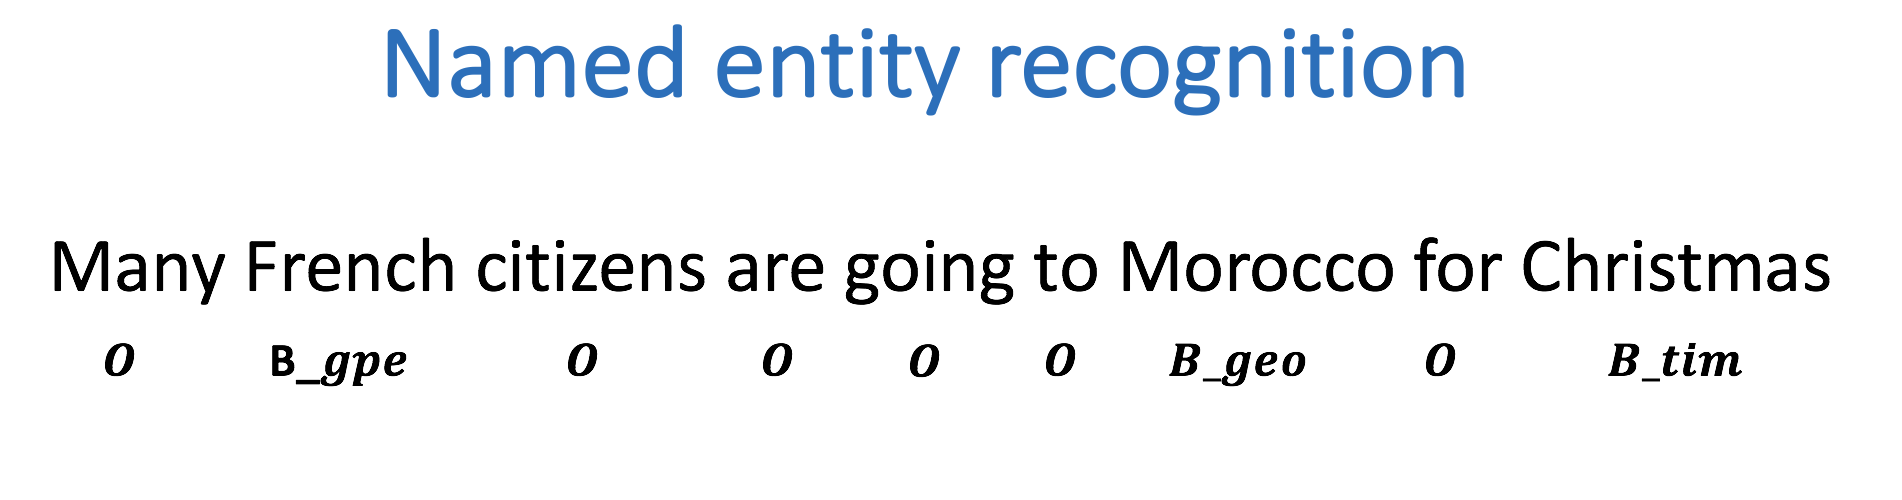

In [1]:
from IPython.display import Image
Image(filename='/Users/amanprasad/Documents/Courses_IIT_Fall_2019/NLP/Named_Entity_Recognition/ner.png')

Is labeled as follows: 

- French: geopolitical entity
- Morocco: geographic entity 
- Christmas: time indicator

Everything else that is labeled with an `O` is not considered to be a named entity.

In [3]:
#!pip -q install trax==1.3.1

import trax 
from trax import layers as tl
import os 
import numpy as np
import pandas as pd


from utils import get_params, get_vocab
import random as rnd

# set random seeds to make this notebook easier to replicate
trax.supervised.trainer_lib.init_random_number_generators(33)

DeviceArray([ 0, 33], dtype=uint32)

## Exploring the data

We will be using preprocessed data. The original data consists of four columns, the sentence number, the word, the part of speech of the word, and the tags.  A few tags we might expect to see are: 

* geo: geographical entity
* org: organization
* per: person 
* gpe: geopolitical entity
* tim: time indicator
* art: artifact
* eve: event
* nat: natural phenomenon
* O: filler word


In [6]:
# display original kaggle data
data = pd.read_csv("ner_dataset.csv", encoding = "ISO-8859-1") 
train_sents = open('data/small/train/sentences.txt', 'r').readline()
train_labels = open('data/small/train/labels.txt', 'r').readline()
print('SENTENCE:', train_sents)
print('SENTENCE LABEL:', train_labels)
print('ORIGINAL DATA:\n', data.head(5))
del(data, train_sents, train_labels)

SENTENCE: Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

SENTENCE LABEL: O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

ORIGINAL DATA:
     Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1          NaN             of   IN   O
2          NaN  demonstrators  NNS   O
3          NaN           have  VBP   O
4          NaN        marched  VBN   O


## Importing the Data

In [7]:
vocab, tag_map = get_vocab('data/large/words.txt', 'data/large/tags.txt')
t_sentences, t_labels, t_size = get_params(vocab, tag_map, 'data/large/train/sentences.txt', 'data/large/train/labels.txt')
v_sentences, v_labels, v_size = get_params(vocab, tag_map, 'data/large/val/sentences.txt', 'data/large/val/labels.txt')
test_sentences, test_labels, test_size = get_params(vocab, tag_map, 'data/large/test/sentences.txt', 'data/large/test/labels.txt')

`vocab` is a dictionary that translates a word string to a unique number. Given a sentence, we can represent it as an array of numbers translating with this dictionary. The dictionary contains a `<PAD>` token. 

When training an LSTM using batches, all our input sentences must be the same size. To accomplish this, we set the length of our sentences to a certain number and add the generic `<PAD>` token to fill all the empty spaces. 

In [8]:
# vocab translates from a word to a unique number
print('vocab["the"]:', vocab["the"])
# Pad token
print('padded token:', vocab['<PAD>'])

vocab["the"]: 9
padded token: 35180


In [9]:
print(tag_map)

{'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-per': 3, 'I-geo': 4, 'B-org': 5, 'I-org': 6, 'B-tim': 7, 'B-art': 8, 'I-art': 9, 'I-per': 10, 'I-gpe': 11, 'I-tim': 12, 'B-nat': 13, 'B-eve': 14, 'I-eve': 15, 'I-nat': 16}


So the coding scheme that tags the entities is a minimal one where B- indicates the first token in a multi-token entity, and I- indicates one in the middle of a multi-token entity. If we had the sentence 

**"Sharon flew to Miami on Friday"**

the outputs would look like:

```
Sharon B-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

our tags would reflect three tokens beginning with B-, since there are no multi-token entities in the sequence. But if we added Sharon's last name to the sentence: 

**"Sharon Floyd flew to Miami on Friday"**

```
Sharon B-per
Floyd  I-per
flew   O
to     O
Miami  B-geo
on     O
Friday B-tim
```

then our tags would change to show first "Sharon" as B-per, and "Floyd" as I-per, where I- indicates an inner token in a multi-token sequence.

In [10]:
# Exploring information about the data
print('The number of outputs is tag_map', len(tag_map))
# The number of vocabulary tokens (including <PAD>)
g_vocab_size = len(vocab)
print(f"Num of vocabulary words: {g_vocab_size}")
print('The vocab size is', len(vocab))
print('The training size is', t_size)
print('The validation size is', v_size)
print('An example of the first sentence is', t_sentences[0])
print('An example of its corresponding label is', t_labels[0])

The number of outputs is tag_map 17
Num of vocabulary words: 35181
The vocab size is 35181
The training size is 33570
The validation size is 7194
An example of the first sentence is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 1, 16, 17, 18, 19, 20, 21]
An example of its corresponding label is [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


So we can see that we have already encoded each sentence into a tensor by converting it into a number. We also have 16 possible classes, as shown in the tag map.


## Data generator

We implement a data generator function that takes in `batch_size, x, y, pad, shuffle` where x is a large list of sentences, and y is a list of the tags associated with those sentences and pad is a pad value. Return a subset of those inputs in a tuple of two arrays `(X,Y)`. Each is an array of dimension (`batch_size, max_len`), where `max_len` is the length of the longest sentence *in that batch*. We will pad the X and Y examples with the pad argument. If `shuffle=True`, the data will be traversed in a random form.

**Details:**

This code as an outer loop  
```
while True:  
...  
yield((X,Y))  
```

Which runs continuously in the fashion of generators, pausing when yielding the next values. We will generate a batch_size output on each pass of this loop.    

It has two inner loops. 
1. The first stores in temporal lists the data samples to be included in the next batch, and finds the maximum length of the sentences contained in it. By adjusting the length to include only the size of the longest sentence in each batch, overall computation is reduced. 

2. The second loop moves those inputs from the temporal list into NumPy arrays pre-filled with pad values.

In [11]:
def data_generator(batch_size, x, y, pad, shuffle=False, verbose=False):
    '''
      Input: 
        batch_size - integer describing the batch size
        x - list containing sentences where words are represented as integers
        y - list containing tags associated with the sentences
        shuffle - Shuffle the data order
        pad - an integer representing a pad character
        verbose - Print information during runtime
      Output:
        a tuple containing 2 elements:
        X - np.ndarray of dim (batch_size, max_len) of padded sentences
        Y - np.ndarray of dim (batch_size, max_len) of tags associated with the sentences in X
    '''
    
    # count the number of lines in data_lines
    num_lines = len(x)
    
    # create an array with the indexes of data_lines that can be shuffled
    lines_index = [*range(num_lines)]
    
    # shuffle the indexes if shuffle is set to True
    if shuffle:
        rnd.shuffle(lines_index)
    
    index = 0 # tracks current location in x, y
    while True:
        buffer_x = [0] * batch_size # Temporal array to store the raw x data for this batch
        buffer_y = [0] * batch_size # Temporal array to store the raw y data for this batch
                
        
        # Reset the index if we reach the end of the data set, and shuffle the indexes if needed.
        max_len = 0
        for i in range(batch_size):
             # if the index is greater than or equal to the number of lines in x
            if index >= num_lines:
                # then reset the index to 0
                index = 0
                # re-shuffle the indexes if shuffle is set to True
                if shuffle:
                    rnd.shuffle(index)
            
            # Store the x value at the current position into the buffer_x
            buffer_x[i] = x[lines_index[index]]
            
            # Store the y value at the current position into the buffer_y
            buffer_y[i] = y[lines_index[index]]
            
            lenx = len(x[lines_index[index]])    
            if lenx > max_len:
                max_len = lenx                   
            
            # increment index by one
            index += 1

        X = np.full((batch_size,max_len),pad)
        Y = np.full((batch_size,max_len),pad)

        for i in range(batch_size):
            x_i = buffer_x[i]
            
            y_i = buffer_y[i]
            
            # Walk through each word in x_i
            for j in range(len(x_i)):
                # store the word in x_i at position j into X
                X[i, j] = x_i[j]
                
                # store the label in y_i at position j into Y
                Y[i, j] = y_i[j]

        if verbose: print("index=", index)
        yield((X,Y))

In [12]:
print([*range(len(t_sentences[0: 8]))])
print(t_sentences[0: 8])

[0, 1, 2, 3, 4, 5, 6, 7]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 9, 15, 1, 16, 17, 18, 19, 20, 21], [22, 1, 23, 24, 11, 9, 25, 26, 9, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 35, 13, 35, 40, 9, 41, 21, 35], [42, 4, 18, 9, 43, 1, 44, 7, 45, 46, 11, 47, 48, 21], [49, 50, 9, 51, 1, 52, 53, 54, 55, 56, 57, 58, 59, 60, 21], [61, 8, 62, 63, 9, 64, 1, 9, 65, 66, 1, 67, 68, 69, 70, 71, 11, 9, 72, 73, 74, 75, 1, 76, 21], [61, 77, 78, 79, 80, 67, 68, 81, 11, 9, 12, 25, 13, 9, 82, 83, 1, 84, 16, 17, 11, 19, 20, 21], [61, 6, 85, 86, 87, 1, 88, 89, 90, 11, 91, 92, 93, 94, 95, 93, 96, 93, 13, 97, 21], [61, 98, 99, 100, 101, 78, 7, 102, 103, 104, 1, 105, 11, 106, 107, 63, 108, 7, 109, 7, 110, 68, 111, 1, 112, 113, 114, 21]]


In [13]:
batch_size = 5
mini_sentences = t_sentences[0: 8]
mini_labels = t_labels[0: 8]
dg = data_generator(batch_size, mini_sentences, mini_labels, vocab["<PAD>"], shuffle=False, verbose=True)
X1, Y1 = next(dg)
X2, Y2 = next(dg)
print(Y1.shape, X1.shape, Y2.shape, X2.shape)
print(X1[0][:], "\n", Y1[0][:])

index= 5
index= 2
(5, 30) (5, 30) (5, 30) (5, 30)
[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14     9    15     1    16    17    18    19    20    21
 35180 35180 35180 35180 35180 35180] 
 [    0     0     0     0     0     0     1     0     0     0     0     0
     1     0     0     0     0     0     2     0     0     0     0     0
 35180 35180 35180 35180 35180 35180]


# Building the model

The model architecture is as follows: 

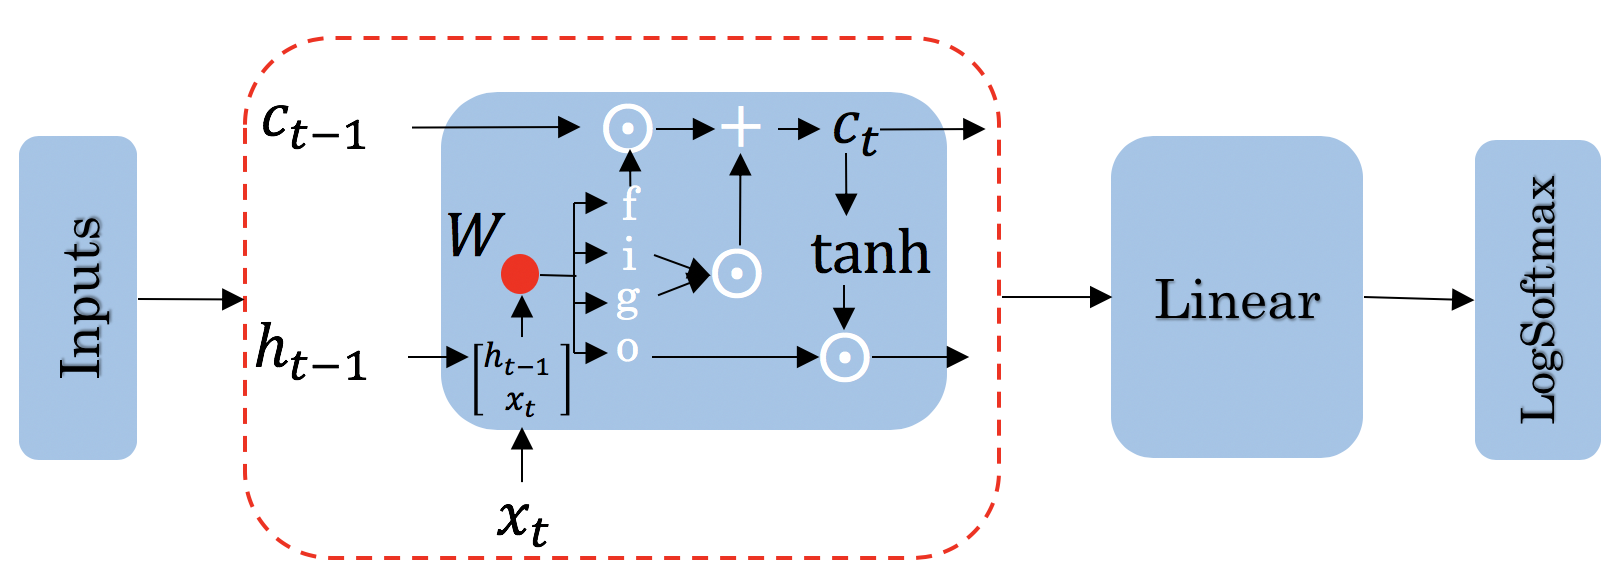

In [14]:
Image(filename='/Users/amanprasad/Documents/Courses_IIT_Fall_2019/NLP/Named_Entity_Recognition/ner2.png')

Steps:
- Use the input tensors we built in our data generator
- Feed it into an Embedding layer, to produce more semantic entries
- Feed it into an LSTM layer
- Run the output through a linear layer
- Run the result through a log softmax layer to get the predicted class for each word.

In [15]:
def NER(vocab_size=35181, d_model=50, tags=tag_map):
    '''
      Input: 
        vocab_size - integer containing the size of the vocabulary
        d_model - integer describing the embedding size
      Output:
        model - a trax serial model
    '''
    model = tl.Serial(
      tl.Embedding(vocab_size, d_model), # Embedding layer
      tl.LSTM(d_model), # LSTM layer
      tl.Dense(len(tags)), # Dense layer with len(tags) units
      tl.LogSoftmax()  # LogSoftmax layer
      )
      
    return model

In [16]:
# initializing our model
model = NER()
# display our model
print(model)

Serial[
  Embedding_35181_50
  LSTM_50
  Dense_17
  LogSoftmax
]


## Train the Model 

Before we start, we need to create the data generators for training and validation data. It is important that we mask padding in the loss weights of our data, which can be done using the `id_to_mask` argument of `trax.supervised.inputs.add_loss_weights`.

In [18]:
from trax.supervised import training

rnd.seed(33)

batch_size = 64

train_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, t_sentences, t_labels, vocab['<PAD>'], True),
    id_to_mask=vocab['<PAD>'])

eval_generator = trax.supervised.inputs.add_loss_weights(
    data_generator(batch_size, v_sentences, v_labels, vocab['<PAD>'], True),
    id_to_mask=vocab['<PAD>'])

In [19]:
def train_model(NER, train_generator, eval_generator, train_steps=1, output_dir='model'):
    '''
    Input: 
        NER - the model we are building
        train_generator - The data generator for training examples
        eval_generator - The data generator for validation examples,
        train_steps - number of training steps
        output_dir - folder to save our model
    Output:
        training_loop - a trax supervised training Loop
    '''
    train_task = training.TrainTask(
      train_generator,  # A train data generator
      loss_layer = tl.CrossEntropyLoss(), # A cross-entropy loss function
      optimizer = trax.optimizers.Adam(0.01), # The adam optimizer
    )

    eval_task = training.EvalTask(
      labeled_data = eval_generator,  # A labeled data generator
      metrics = [tl.CrossEntropyLoss(), tl.Accuracy()], # Evaluate with cross-entropy loss and accuracy
      n_eval_batches = 10 # Number of batches to use on each evaluation
    )

    training_loop = training.Loop(
        NER, # A model to train
        train_task, # A train task
        eval_task = eval_task, # The evaluation task
        output_dir = output_dir) # The output directory

    # Train with train_steps
    training_loop.run(n_steps = train_steps)
    
    return training_loop

In [20]:
train_steps = 400           

# Train the model
training_loop = train_model(NER(), train_generator, eval_generator, train_steps)

Step      1: train CrossEntropyLoss |  3.29933977
Step      1: eval  CrossEntropyLoss |  2.27930477
Step      1: eval          Accuracy |  0.22279498
Step    100: train CrossEntropyLoss |  0.61237383
Step    100: eval  CrossEntropyLoss |  0.37608673
Step    100: eval          Accuracy |  0.90983244
Step    200: train CrossEntropyLoss |  0.30366319
Step    200: eval  CrossEntropyLoss |  0.24882581
Step    200: eval          Accuracy |  0.93492962
Step    300: train CrossEntropyLoss |  0.23334143
Step    300: eval  CrossEntropyLoss |  0.21312232
Step    300: eval          Accuracy |  0.94296402
Step    400: train CrossEntropyLoss |  0.19667082
Step    400: eval  CrossEntropyLoss |  0.18756753
Step    400: eval          Accuracy |  0.94566598


## Compute Accuracy

We will now evaluate in the test set. Previously, we have seen the accuracy on the training set and the validation (noted as eval) set. We will now evaluate on our test set. To get a good evaluation, we will need to create a mask to avoid counting the padding tokens when computing the accuracy.

In [21]:
# create the evaluation inputs
x, y = next(data_generator(len(test_sentences), test_sentences, test_labels, vocab['<PAD>']))
print("input shapes", x.shape, y.shape)

input shapes (7194, 70) (7194, 70)


In [22]:
tmp_pred = training_loop.eval_model(x)

In [23]:
# sample prediction
print(type(tmp_pred))
print(f"tmp_pred has shape: {tmp_pred.shape}")

<class 'jax.interpreters.xla.DeviceArray'>
tmp_pred has shape: (7194, 70, 17)


We see that the model's prediction has 3 axes: 
- the number of examples
- the number of words in each example (padded to be as long as the longest sentence in the batch)
- the number of possible targets (the 17 named entity tags).

In [25]:
def evaluate_prediction(pred, labels, pad):
    """
    Inputs:
        pred: prediction array with shape 
            (num examples, max sentence length in batch, num of classes)
        labels: array of size (batch_size, seq_len)
        pad: integer representing pad character
    Outputs:
        accuracy: float
    """
    outputs = np.argmax(pred, axis=2)
    print("outputs shape:", outputs.shape)

    mask = labels != pad
    print("mask shape:", mask.shape, "mask[0][20:30]:", mask[0][20:30])

    accuracy = np.sum(outputs == labels) / float(np.sum(mask))

    return accuracy

In [26]:
accuracy = evaluate_prediction(training_loop.eval_model(x), y, vocab['<PAD>'])
print("accuracy: ", accuracy)

outputs shape: (7194, 70)
mask shape: (7194, 70) mask[0][20:30]: [ True  True  True False False False False False False False]
accuracy:  0.9461064813036855


## Testing with our own sentence

In [27]:
def predict(sentence, model, vocab, tag_map):
    s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
    batch_data = np.ones((1, len(s)))
    batch_data[0][:] = s
    sentence = np.array(batch_data).astype(int)
    output = model(sentence)
    outputs = np.argmax(output, axis=2)
    labels = list(tag_map.keys())
    pred = []
    for i in range(len(outputs[0])):
        idx = outputs[0][i] 
        pred_label = labels[idx]
        pred.append(pred_label)
    return pred

In [28]:
# New york times news:
sentence = "Peter Navarro, the White House director of trade and manufacturing policy of U.S, said in an interview on Sunday morning that the White House was working to prepare for the possibility of a second wave of the coronavirus in the fall, though he said it wouldn’t necessarily come"
s = [vocab[token] if token in vocab else vocab['UNK'] for token in sentence.split(' ')]
predictions = predict(sentence, training_loop.eval_model, vocab, tag_map)
for x,y in zip(sentence.split(' '), predictions):
    if y != 'O':
        print(x,y)

Peter B-per
White B-org
House I-org
Sunday B-tim
morning I-tim
White B-org
House I-org
